In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding
from keras.models import load_model
from tensorflow.keras.utils import plot_model

2.4.1


In [3]:
sequence_length=10
min_word_frequency=30
step=1
batch_size=32

**Shuffle and split training set**

In [4]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [5]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length), dtype=np.int32)
    y=np.zeros((batch_size), dtype=np.int32)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t]=word_indices[w]
      y[i]=word_indices[next_word_list[index%len(sentence_list)]]
      index+=1                                             
    yield x, y

**Write generated vocabulary to a file**

In [6]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [7]:
def get_model(dropout=0.2):
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Embedding(input_dim=len(words), output_dim=1024))
    model.add(Bidirectional(LSTM(128)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model

In [8]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [9]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length))
      for t, word in enumerate(sentence):
        x_pred[0, t]= word_indices[word]
      ##print("Generating predictions...")
      preds=model.predict(x_pred, verbose=0)[0]
      #print("Done!")
      #print("Generating next index...")
      next_index=sample(preds, diversity)
      #print("Done!")
      #print("Generating next word...")
      next_word=indices_word[next_index]
      #print("Done!")
      #print("Updating sentence value...")
      sentence=sentence[1:]
      #print("Done!")
      #print("Appending to sentence...")
      sentence.append(next_word)
      #print("Done!!!!!!!!!")
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Michael Connelly**

In [10]:
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Michael Connelly.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_michael_connelly.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_michael_connelly.txt'

In [11]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints')

In [12]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 17592785


In [13]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 3268280


In [14]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [15]:
len(word_freq)

87743

In [16]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [17]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
print_vocabulary(vocabulary, words)

Unique words before ignoring: 87743
Unique words after ignoring: 7028


In [18]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [19]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [20]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  2087864
Remaning sentences:  1180406
Number of words:  1180406


In [21]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 1156797
Size of test set= 23609


In [22]:
model=get_model()

Build model...
Done!


In [23]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

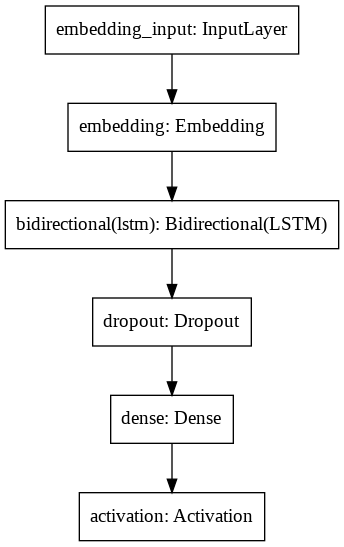

In [25]:
plot_model(model, to_file='Michael Connelly.png')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 1024)        7196672   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               1180672   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 7028)              1806196   
_________________________________________________________________
activation (Activation)      (None, 7028)              0         
Total params: 10,183,540
Trainable params: 10,183,540
Non-trainable params: 0
_________________________________________________________________


In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
int(len(sentences_test)/batch_size)+1

738

In [ ]:
with tf.device('/gpu:0'):
  history=model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=100, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/model_michael_connelly.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_michael_connelly.h5")
print("Saved model to disk!")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
36150/36150 [==============================] - 2657s 73ms/step - loss: 5.4547 - accuracy: 0.1537 - val_loss: 4.7359 - val_accuracy: 0.2016


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch001-words7028-sequence10-minfreq30-loss5.1030-accuracy0.1767-val_loss4.7359-val_accuracy0.2016/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch001-words7028-sequence10-minfreq30-loss5.1030-accuracy0.1767-val_loss4.7359-val_accuracy0.2016/assets


Epoch 2/100
36150/36150 [==============================] - 2656s 73ms/step - loss: 4.7478 - accuracy: 0.1993 - val_loss: 4.6376 - val_accuracy: 0.2085


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch002-words7028-sequence10-minfreq30-loss4.7156-accuracy0.2020-val_loss4.6376-val_accuracy0.2085/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch002-words7028-sequence10-minfreq30-loss4.7156-accuracy0.2020-val_loss4.6376-val_accuracy0.2085/assets


Epoch 3/100
36150/36150 [==============================] - 2714s 75ms/step - loss: 4.6286 - accuracy: 0.2089 - val_loss: 4.6101 - val_accuracy: 0.2126


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch003-words7028-sequence10-minfreq30-loss4.6158-accuracy0.2101-val_loss4.6101-val_accuracy0.2126/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch003-words7028-sequence10-minfreq30-loss4.6158-accuracy0.2101-val_loss4.6101-val_accuracy0.2126/assets


Epoch 4/100
36150/36150 [==============================] - 2727s 75ms/step - loss: 4.5654 - accuracy: 0.2139 - val_loss: 4.5869 - val_accuracy: 0.2161


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch004-words7028-sequence10-minfreq30-loss4.5578-accuracy0.2148-val_loss4.5869-val_accuracy0.2161/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch004-words7028-sequence10-minfreq30-loss4.5578-accuracy0.2148-val_loss4.5869-val_accuracy0.2161/assets


Epoch 5/100
36150/36150 [==============================] - 2729s 76ms/step - loss: 4.5271 - accuracy: 0.2177 - val_loss: 4.5822 - val_accuracy: 0.2169


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch005-words7028-sequence10-minfreq30-loss4.5255-accuracy0.2183-val_loss4.5822-val_accuracy0.2169/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch005-words7028-sequence10-minfreq30-loss4.5255-accuracy0.2183-val_loss4.5822-val_accuracy0.2169/assets


Epoch 6/100
36150/36150 [==============================] - 2770s 77ms/step - loss: 4.5079 - accuracy: 0.2200 - val_loss: 4.5798 - val_accuracy: 0.2177


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch006-words7028-sequence10-minfreq30-loss4.5082-accuracy0.2204-val_loss4.5798-val_accuracy0.2177/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch006-words7028-sequence10-minfreq30-loss4.5082-accuracy0.2204-val_loss4.5798-val_accuracy0.2177/assets


Epoch 7/100
36150/36150 [==============================] - 2767s 77ms/step - loss: 4.4969 - accuracy: 0.2216 - val_loss: 4.5837 - val_accuracy: 0.2184


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch007-words7028-sequence10-minfreq30-loss4.4989-accuracy0.2220-val_loss4.5837-val_accuracy0.2184/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch007-words7028-sequence10-minfreq30-loss4.4989-accuracy0.2220-val_loss4.5837-val_accuracy0.2184/assets


Epoch 8/100
36150/36150 [==============================] - 2759s 76ms/step - loss: 4.4879 - accuracy: 0.2227 - val_loss: 4.5874 - val_accuracy: 0.2171
Epoch 9/100
29052/36150 [=======================>......] - ETA: 8:52 - loss: 4.4835 - accuracy: 0.2231

In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/checkpoints/METG-epoch001-words7028-sequence10-minfreq30-loss4.5785-accuracy0.2213-val_loss4.4098-val_accuracy0.2283"
from keras.models import load_model
model=load_model(model_file)

In [ ]:
with tf.device('/gpu:0'):
  history=model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=100, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)
from keras.models import model_from_json


Epoch 1/100
    2/36150 [..............................] - ETA: 42:16 - loss: 4.2874 - accuracy: 0.2812

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


36150/36150 [==============================] - 2543s 70ms/step - loss: 4.5139 - accuracy: 0.2220 - val_loss: 4.4392 - val_accuracy: 0.2266
Epoch 2/100
36150/36150 [==============================] - 2527s 70ms/step - loss: 4.5020 - accuracy: 0.2227 - val_loss: 4.4769 - val_accuracy: 0.2232
Epoch 3/100
 7643/36150 [=====>........................] - ETA: 33:11 - loss: 4.4866 - accuracy: 0.2241

In [ ]:
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/model_michael_connelly.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/model_michael_connelly.h5")
print("Saved model to disk!")

Saved model to disk!


In [ ]:
##model=get_model()
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Michael Connelly/model_michael_connelly.h5")

**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, 
                  seed, sequence_length, diversity, 
                  quantity, vocabulary, write_path, 
                  write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length))
    for t, word in enumerate(sentence):
      x_pred[0, t]= word_indices[word]
    ##print("Generating predictions...")
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
##vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_michael_connelly.txt"

In [ ]:
##model=load_model(model_file)
##vocabulary=open(vocabulary_file, "r").readlines()
##print(len(vocabulary))

In [ ]:
#import re
#vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
#word_indices=dict((c, i) for i, c in enumerate(words))
#indices_word=dict((i, c) for i, c in enumerate(words))

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=300
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Michael Connelly/", 
                True, "Michael Connelly")
  print("=====================================================")

Seed sentence: out doing the talking again. "we need to clear up
====Generating text====
Diversity:  0.3
Seed sentence: out doing the talking again. "we need to clear up
out doing the talking again. "we need to clear up up the case to make a mistake. you know, i
 want to know what i was going to say to
 him. i was still in the room. i was looking
 at the defense and i was on the table. i
 was a little bit of the first time i was
 going to be able to get a message to the
 other in the case and they were in the car.
 they were going to the house and then went to
 the door and walked back to the door. he was
 still in the room and he was going to make
 a move with the two detectives in the room and
 the police were in the car. he was a cop.
 he had the same time in the office to get
 the car and i got out of the car and
 got out of the car. he was going to be
 the one of the man who had told him the
 story was the only way to the case and i
 was in the courtroom for the time of the case
 

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Michael Connelly/", True, "Michael Connelly")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 next time who had gone to the car. the judge
 wanted to get it to the judge and we can
 get it out.” she turned and looked at the photo
 to the screen again. the man was still in the
 car. i went into the apartment and i was on
 the way down to the room to check a key
 with a matching stack of files and the notebook in
 front of his desk that was the only one needed
 to be. he had a video to the office was
 a interview on the judge’s desk. she was a man
 who was in the back. he was a chance, a
 lot of things and it was a good time for
 the day there. i could see a lot of things
 that was a good crime of supposed to be a
 good case against the defense and my story is a
 motion to see a jury be in your car.” “i
 guess it was your other back to the next door
 of the car and in the room were a pile
 on the bed table in front of the house on
 the computer and three other way up and started to
 make the call to him. if it was a cop.
 he pul